In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import textwrap


In [21]:
# Hyperparameters
random_seed = 3221
torch.manual_seed(random_seed)
batch_size = 128
block_size = 256
num_blocks = 4
head_num = 12
embedding_dim = 192
validation_split = 0.2
device = "cuda" if torch.cuda.is_available() else "cpu"
wrapped_width = 50
hidden_dim = 768
num_epochs = 1000
learning_rate = 5e-4
weight_decay = 0.06
patience = 100
dropout_rate = 0.1

num_interval = max(num_epochs // 10, 50)  # 每5%的epochs或至少每10个epochs验证一次
head_size = embedding_dim // head_num


In [22]:
# 数据处理
# token化, 建立从字符到向量,向量到字符的双向映射

file_name = "data/literature.txt"

with open(file_name, 'r', encoding="utf-8") as f:
    text = f.read()

# 有序的字符集合
chars = sorted(list(set(text)))
# 保存字符集合
with open("data/chars.txt", "w", encoding="utf-8") as f:
    f.write("".join(chars))

# 字符到数字的映射
c2i = {c:i for i, c in enumerate(chars)}
i2c = {i:c for i, c in enumerate(chars)}

# 编码: 字符串 -> 数字列表
# 解码: 数字列表 -> 字符串
encode = lambda x: [c2i[c] for c in x]
decode = lambda x: "".join([i2c[i] for i in x])

print("字典大小:", len(c2i))
print("字符集合:", chars)


字典大小: 3811
字符集合: ['\n', ' ', '!', '"', '#', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '^', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '°', '·', '×', 'à', 'á', 'è', 'é', 'ü', 'ī', 'ū', 'ǎ', 'α', 'ω', '–', '—', '―', '‘', '’', '“', '”', '…', '′', '℃', '∶', '①', '②', '③', '④', '◎', '\u3000', '、', '。', '《', '》', '一', '丁', '七', '万', '丈', '三', '上', '下', '不', '与', '丐', '丑', '专', '且', '世', '丘', '丙', '业', '丛', '东', '丝', '丢', '两', '严', '丧', '个', '中', '丰', '串', '临', '丸', '丹', '为', '主', '丽', '举', '乃', '久', '么', '义', '之', '乌', '乍', '乎', '乏', '乐', '乒', '乓', '乔', '乖', '乘', '乙', '九', '乞', '也', '习', '乡', '书', '买', '乱', '乳', '乾', '了', '予', '争', '事', '二', '于', '亏', '云', '互', '五', '

In [23]:
# 数据分批
# 1. 划分数据集
data = torch.tensor(encode(text), dtype=torch.long)
valid_size = int(len(text) * validation_split)
valid_data = data[valid_size:]
train_data = data[:valid_size]

# 2. get_batch函数
# 从数据集中随机取出batch_size个数据
# 输入: split - "valid" or "train"
# 输出: (batch_size, block_size)的tensor
def get_batch(split):
    data = valid_data if split == "valid" else train_data
    idx = torch.randint(0, len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in idx])
    y = torch.stack([data[i+1:i+1+block_size] for i in idx])
    # x是字符串的列表, y是x的下一个字符的列表
    x, y = x.to(device), y.to(device)
    return x, y

x, y = get_batch("train")






In [24]:
# Embedding
vocab_size = len(chars)


# 词嵌入
# 第一个参数是词典大小, 第二个参数是词向量维度
token_embedding_table = nn.Embedding(vocab_size, embedding_dim).to(device)
token_ebd = token_embedding_table(x).to(device)
# 位置嵌入
position_embedding_table = nn.Embedding(block_size, embedding_dim).to(device)
position_ebd = position_embedding_table(torch.arange(block_size).to(device)).unsqueeze(0)


print("位置嵌入:", position_ebd.shape)


位置嵌入: torch.Size([1, 256, 192])


In [25]:
# Heads
class Head(nn.Module):
    def __init__(self, head_size = head_size):
        super().__init__()
        self.value = nn.Linear(embedding_dim, head_size, bias=False)
        self.query = nn.Linear(embedding_dim, head_size, bias=False)
        self.key = nn.Linear(embedding_dim, head_size, bias=False)
        # 生成一个不可训练的下三角矩阵
        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        # x: (batch_size, block_size, embedding_dim)
        # return: (batch_size, block_size, head_size)
        # 每个head有一个value矩阵, 用于计算attention
        B, T, C = x.shape
        Q = self.query(x)
        K = self.key(x)
        attention = Q @ K.transpose(-2, -1) * C ** -0.5
        attention = attention.masked_fill(self.mask == 0, float('-inf'))
        # 输出的结果是 value向量 * attention
        V = self.value(x)
        
        attention = F.softmax(attention, dim=-1)
        out = attention @ V # (B, T, head_size)
        return  self.dropout(out)
    
class MultiHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.heads = nn.ModuleList([Head() for _ in range(head_num)])
        self.fc = nn.Linear(head_num * head_size, embedding_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        # x: (batch_size, block_size, embedding_dim)
        # return: (batch_size, block_size, embedding_dim)
        out = self.fc(torch.cat([h(x) for h in self.heads], dim=-1))
        out = self.dropout(out)
        return out
        
class Block(nn.Module):
    def __init__(self):
        super().__init__()
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ln2 = nn.LayerNorm(embedding_dim)
        self.sa = MultiHead()
        self.ff = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, embedding_dim),
            nn.Dropout(dropout_rate)
        )
    
    def forward(self, x):
        # x: (batch_size, block_size, embedding_dim)
        # return: (batch_size, block_size, embedding_dim)
        out = x + self.sa(self.ln1(x))
        out = self.ln2(out + self.ff(out))
        return out
                         

In [26]:
# Model
class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
     
        self.vocab_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(block_size, embedding_dim)
        self.blocks = nn.Sequential(*[Block() for _ in range(num_blocks)])
        self.dropout = nn.Dropout(0.2)
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.fc = nn.Linear(embedding_dim, vocab_size)
        
    # x: (batch_size, block_size) 单位是token
    # target: (batch_size, block_size) 单位是token
    # 返回: (batch_size, block_size, vocab_size) logits
    def forward(self, x, target=None):
        B, T = x.shape
        
        ve = self.vocab_embedding(x)
        pe = self.position_embedding(torch.arange(T).to(device))
        h = ve + pe # (B, T, E)
        h = self.blocks(h)
        h = self.ln_f(h)
        logits = self.fc(h)
        
        # 计算loss
        if target is not None:
            loss = F.cross_entropy(logits.view(B*T, -1), target.view(-1))
        else:
            loss = None
        return logits, loss
    
    # 生成
    # token_seq: (batch_size, block_size) 上文, 单位是token
    # max_token: int 最大生成长度
    # 返回: (batch_size, max_token) 生成的token序列
    def generate(self, token_seq, max_token):
        for _ in range(max_token):
            # 取最后block_size个token
            token_input = token_seq[:, -block_size:]
            # 计算logits
            logits, loss = self.forward(token_input)
            # 取字符串的最后一个字符, 目前还只是网络直接输出的结果
            logits = logits[:, -1, :]
            # softmax,维度是-1,也就是vocabulary的维度
            prob = F.softmax(logits, dim=-1)
            # 采样, 输出是下一个token,形状是(batch_size, 1)
            next_token = torch.multinomial(prob, 1)
            # 拼接到token_seq后面, 在时间维度上
            token_seq = torch.cat([token_seq, next_token], dim=1)
        return token_seq[:, -max_token:]

@torch.no_grad()
def estimate(model):
    splits = ["train", "valid"]
    model.eval()
    out = {}

    for split in splits:
        losses = torch.zeros(num_interval)
        for i in range(num_interval):
            x, y = get_batch(split)
            logits, loss = model(x, y)
            losses[i] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out
            
            

In [27]:
# 训练
model = LanguageModel().to(device)
best_val_loss = float('inf')
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
counter = 0

for epoch in range(num_epochs):
    x, y = get_batch("train")
    logits, loss = model(x, y) #前馈运算
    optimizer.zero_grad()
    loss.backward() # 反向传播
    optimizer.step()
    if epoch % num_interval == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        result = estimate(model)
        print("Train Loss:", result["train"].item())
        val_loss = result["valid"].item()
        print("Valid Loss:", val_loss)
        print("-" * wrapped_width)
    if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            # 保存模型
            torch.save(model.state_dict(), "model.pth")
    else:
        counter += 1
        
    if counter >= patience:
        print('Early stopping!')
        break

    


Epoch 0, Loss: 8.412135124206543
Train Loss: 8.115385055541992
Valid Loss: 8.124889373779297
--------------------------------------------------
Epoch 100, Loss: 5.311680793762207
Train Loss: 5.232851982116699
Valid Loss: 5.768039703369141
--------------------------------------------------
Epoch 200, Loss: 4.538897514343262
Train Loss: 4.509884357452393
Valid Loss: 5.323651313781738
--------------------------------------------------
Epoch 300, Loss: 4.282341480255127
Train Loss: 4.204404354095459
Valid Loss: 5.213500499725342
--------------------------------------------------
Epoch 400, Loss: 4.078436851501465
Train Loss: 4.0135650634765625
Valid Loss: 5.163753032684326
--------------------------------------------------
Epoch 500, Loss: 3.9056577682495117
Train Loss: 3.8425979614257812
Valid Loss: 5.133504867553711
--------------------------------------------------
Epoch 600, Loss: 3.766578435897827
Train Loss: 3.689257860183716
Valid Loss: 5.1122727394104
------------------------------

In [35]:
# 测试生成文字
max_token = 300
start_idx = random.randint(0, len(valid_data) - block_size - max_token)

# 上文内容

context = torch.zeros(1, block_size, dtype=torch.long).to(device)
context[0, :] = valid_data[start_idx:start_idx+block_size]
context_str = decode(context[0].tolist())
wrapped_context = textwrap.fill(context_str, width=80)
# 真实下文内容
real_next_context = torch.zeros(1, max_token, dtype=torch.long).to(device)
real_next_context[0, :] = valid_data[start_idx+block_size:start_idx+block_size+max_token]
next_context_str = decode(real_next_context[0].tolist())
wrapped_real_next_context = textwrap.fill(next_context_str, width=80)

# 生成下文内容
generated_next_context = model.generate(context, max_token)
generated_next_context_str = decode(generated_next_context[0].tolist())
wrapped_generated_next_context = textwrap.fill(generated_next_context_str, width=80)

print("-" * wrapped_width)
print("上文:")
print(wrapped_context)
print("-" * wrapped_width)
print("真实下文:")
print(wrapped_real_next_context)
print("-" * wrapped_width)
print("生成下文:")
print(wrapped_generated_next_context)




--------------------------------------------------
上文:
余。  同时，总的生产规模之扩大，当然增加那种不是直接有赖于个别企业大小的经济。这些经济中最重要的，是由于相关的工业部门的发达而产生的，这些部门互相帮助，也许集
中在同一地方，但无论如何，它们都利用轮船、火车、电报、印刷机等所提供的近代交通便利。像这种来源所产生的各种经济，是任何生产部门都可获得的，而不是完全依靠它自己的
发达：但是，这些经济必然是随着它自己的发达而迅速地和稳步地增大；如果它衰败的话，这些经济在某些方面——  虽然不是在一切方面——必然是缩小的。
第二节　生产费用应当以一个代表性企业来说明，这
--------------------------------------------------
真实下文:
个企业能正常地获得属于一定的总生产量的内部经济与外部经济。报酬不变与报酬递增。  当我们研究支配一种商品的供给价格之各种原因时，这些结果具有很大的重要性。我们必
须仔细分析生产一种商品与一定的总生产量有关的正常费用；为了这个目的，我们将要研究在那个总生产量之下一个代表性生产者的费用。一方面，我们不要选择某一刚刚竭力投身营
业的新生产者为代表，他在许多不利的条件下经营，一时不得不满足于很少的利润或没有利润，但他对以下的事实是满意的；他正在建立营业关系，对于建立成功的营业正有头绪；另
一方面，我们也不要采取这样一个企业为代表：由于非常持久的能力和好运气，它已经有了很大的营业和井井有条的大工场，而这些大工
--------------------------------------------------
生成下文:
些参与备有收入和公司机的关系。雷益似存在深认为，我付不要大多用这一个新加上升的经济信息，它可以先衰退出于他们所作用加就适了此，附高的例外里学习的时就是因素解它。
我的行为使用于学说：无能支付的研究别人地者和银到这家愿意识良好工业，获得将会在因非营销反悔的技能性组织、不同的冒险的一种，看待着较有良好，当地工作更多的陈产也也
就产项目希望财富为是工员。真正越多的和同样的每一种情习这种成为，而是世界上受过的生的心理解它的机会，经纪人就增加了。正式和政府的“后，你想将来看承虚拟时间的梦想
忘镜子。”超过去在太富了贫穷人不变化，还到10美元的

C:\Users\Bikiduke\AppData\Local\Temp\ipykernel_28248\1205791739.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

发现 6020 个高频短语（长度2-4，出现次数≥20）
总嵌入数量：200（单字 100，短语 100）


C:\Users\Bikiduke\AppData\Local\Temp\ipykernel_28248\1205791739.py:213: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Bikiduke\AppData\Local\Temp\ipykernel_28248\1205791739.py:213: UserWarning: Glyph 31526 (\N{CJK UNIFIED IDEOGRAPH-7B26}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Bikiduke\AppData\Local\Temp\ipykernel_28248\1205791739.py:213: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Bikiduke\AppData\Local\Temp\ipykernel_28248\1205791739.py:213: UserWarning: Glyph 30701 (\N{CJK UNIFIED IDEOGRAPH-77ED}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Bikiduke\AppData\Local\Temp\ipykernel_28248\1205791739.py:213: UserWarning: Glyph 35821 (\N{CJK UNIFIED IDEOGRAPH-8BED}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Bikiduke\AppData\Local\Temp\ipykernel_28248\1205791739.py:213: Use

可视化结果已保存为 embedding_viz_fixed.png
(200, 192)
保存交互式可视化到 interactive_viz.html

分析短语 '夏天':
与 '夏天' 最相似的词语：
单字 '天': 0.717
单字 '夏': 0.698
单字 '寐': 0.268
单字 '轰': 0.259
单字 '脆': 0.238
单字 '膛': 0.233
单字 '庖': 0.233
单字 '鄂': 0.231
单字 '诗': 0.227
单字 '菇': 0.226
单字 '己': 0.225
单字 '“': 0.217

分析短语 '夏日':
与 '夏日' 最相似的词语：
单字 '日': 0.687
单字 '夏': 0.653
单字 '庖': 0.243
单字 '宜': 0.239
单字 '女': 0.226
单字 '下': 0.226
单字 '迥': 0.213
单字 '资': 0.206
单字 '共': 0.204
单字 '勘': 0.203
单字 '辞': 0.201
单字 '苍': 0.201

分析短语 '回忆':
与 '回忆' 最相似的词语：
单字 '回': 0.788
单字 '忆': 0.659
单字 '耗': 0.267
单字 '绽': 0.225
单字 '沃': 0.221
单字 '箍': 0.220
单字 '江': 0.219
单字 '寨': 0.218
单字 '胁': 0.212
单字 '^': 0.202
单字 '烤': 0.201
单字 '柏': 0.200

分析短语 '音乐':
与 '音乐' 最相似的词语：
单字 '乐': 0.674
单字 '音': 0.674
单字 '贩': 0.248
单字 '若': 0.235
单字 '凝': 0.229
单字 '瓦': 0.225
单字 '麸': 0.221
单字 '厉': 0.221
单字 '璨': 0.206
单字 '妞': 0.204
单字 '案': 0.196
单字 '阅': 0.195

分析短语 '爱':
与 '爱' 最相似的词语：
单字 '爱': 1.000
单字 '躲': 0.258
单字 '勘': 0.258
单字 '尴': 0.234
单字 '恳': 0.230
单字 '砥': 0.229
单字 '残': 0.222
单字 '硝': 0.217
单字 '蠕':

c:\CS-Learning\MachineLearning\mltrain\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from font(s) DejaVu Sans.

c:\CS-Learning\MachineLearning\mltrain\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 31526 (\N{CJK UNIFIED IDEOGRAPH-7B26}) missing from font(s) DejaVu Sans.

c:\CS-Learning\MachineLearning\mltrain\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) DejaVu Sans.

c:\CS-Learning\MachineLearning\mltrain\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 30701 (\N{CJK UNIFIED IDEOGRAPH-77ED}) missing from font(s) DejaVu Sans.

c:\CS-Learning\MachineLearning\mltrain\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 35821 (\N{CJK UNIFIED IDEOGRAPH-8BED}) missing from font(s) DejaVu Sans.

c:\CS-Learning\MachineLearning\mltrain\Lib\site-packages\IPython\core\pylabtools.py:1

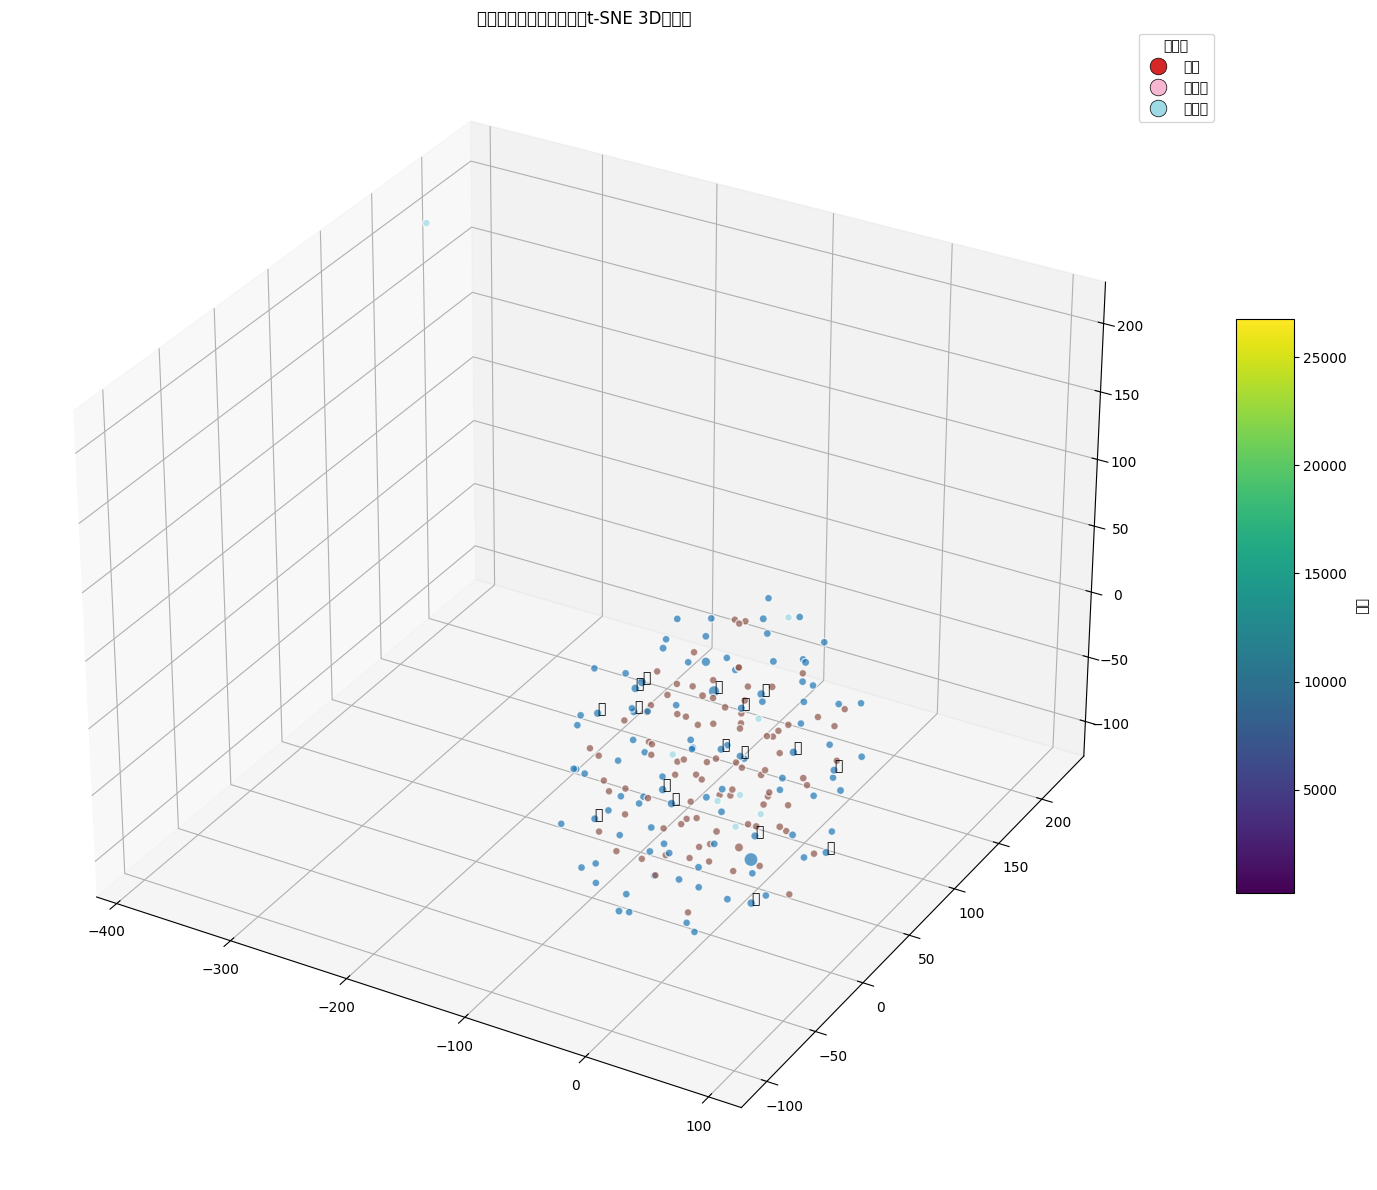

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import plotly.express as px
import os
from collections import defaultdict

# 新增函数：高频短语发现
def discover_phrases(text, min_count=10, max_length=4):
    """发现高频词语组合"""
    phrase_counts = defaultdict(int)
    
    # 发现不同长度的短语
    for length in range(2, max_length+1):
        # 滑动窗口遍历文本
        for i in range(len(text) - length + 1):
            phrase = text[i:i+length]
            phrase_counts[phrase] += 1
    
    # 过滤低频短语
    phrases = {phrase: count for phrase, count in phrase_counts.items() 
              if count >= min_count and len(phrase) >= 2}
    print(f"发现 {len(phrases)} 个高频短语（长度2-{max_length}，出现次数≥{min_count}）")
    return phrases

# 修改后的数据加载函数
def load_data_and_model():
    """加载数据和模型"""
    # 路径配置
    model_path = "model.pth"
    data_path = "data/lyrics_augmented.txt" 
    chars_path = "data/chars.txt"
    
    # 加载字符集
    with open(chars_path, 'r', encoding='utf-8') as f:
        chars = f.read()
    
    # 创建字符到索引的映射
    c2i = {c:i for i, c in enumerate(chars)}
    i2c = {i:c for i, c in enumerate(chars)}
    
    # 加载模型超参数
    vocab_size = len(chars)
    
    # 初始化模型
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LanguageModel().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # 计算词频和短语频率
    word_freqs = defaultdict(int)
    with open(data_path, 'r', encoding='utf-8') as f:
        text = f.read()
        # 单字频率
        for char in text:
            if char in c2i:
                word_freqs[char] += 1
        # 短语发现
        phrases = discover_phrases(text, min_count=20, max_length=4)
        word_freqs.update(phrases)
    
    return model, chars, c2i, i2c, word_freqs, device

# 新增函数：获取短语嵌入
def get_phrase_embedding(phrase, c2i, embedding_matrix):
    """获取短语的嵌入表示（平均池化）"""
    valid_chars = [c for c in phrase if c in c2i]
    if len(valid_chars) == 0:
        return None
    
    # 获取各字符的嵌入
    char_indices = [c2i[c] for c in valid_chars]
    char_embeddings = embedding_matrix[char_indices]
    
    # 平均池化
    return np.mean(char_embeddings, axis=0)

# 修改后的嵌入提取函数
def extract_embeddings(model, chars, c2i, i2c, word_freqs, top_n=100):
    """提取嵌入向量"""
    # 获取词嵌入矩阵
    embedding_matrix = model.vocab_embedding.weight.detach().cpu().numpy()
    
    # 获取频率最高的N个单字
    single_chars = [(k,v) for k,v in word_freqs.items() if len(k) == 1]
    top_words = sorted(single_chars, key=lambda x: x[1], reverse=True)[:top_n]
    top_word_indices = [c2i[word[0]] for word in top_words]
    top_word_embeddings = embedding_matrix[top_word_indices]
    
    # 获取高频短语的嵌入
    phrases = [(k,v) for k,v in word_freqs.items() if len(k) >= 2]
    top_phrases = sorted(phrases, key=lambda x: x[1], reverse=True)[:top_n]
    phrase_embeddings = []
    valid_phrases = []
    
    for phrase, _ in top_phrases:
        emb = get_phrase_embedding(phrase, c2i, embedding_matrix)
        if emb is not None:
            phrase_embeddings.append(emb)
            valid_phrases.append(phrase)
    
    # 组合单字和短语的嵌入
    combined_embeddings = np.vstack([top_word_embeddings, np.array(phrase_embeddings)])
    combined_indices = top_word_indices + valid_phrases
    
    print(f"总嵌入数量：{len(combined_indices)}（单字 {len(top_word_indices)}，短语 {len(valid_phrases)}）")
    return combined_embeddings, combined_indices, embedding_matrix

# 修改后的可视化函数
def visualize_embeddings_3d(combined_indices, embeddings_3d, i2c, word_freqs):
    """3D可视化（修复图例版本）"""
    # t-SNE降维
    tsne = TSNE(n_components=3, random_state=42, perplexity=30)
    embeddings_3d = tsne.fit_transform(embeddings_3d)
    
    # 创建3D散点图
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # 准备可视化数据
    xs = embeddings_3d[:, 0]
    ys = embeddings_3d[:, 1]
    zs = embeddings_3d[:, 2]
    
    # 获取频率和类型（1=单字，2=双字词，依此类推）
    freqs = []
    categories = []
    for idx in combined_indices:
        if isinstance(idx, int):  # 单字
            word = i2c[idx]
            freqs.append(word_freqs[word])
            categories.append(1)
        else:  # 短语
            freqs.append(word_freqs[idx])
            categories.append(len(idx))  # 用长度作为分类
    
    # 正规化点的大小
    sizes = 30 + 70 * (np.array(freqs) - min(freqs)) / (max(freqs) - min(freqs))
    
    # 绘制散点图（使用分类颜色）
    scatter = ax.scatter(
        xs, ys, zs, 
        c=categories,           # 使用分类值
        cmap='tab20',           # 使用定性色板
        s=sizes,                # 大小表示频率
        alpha=0.7,
        marker='o',
        edgecolors='w'
    )
    
    # 添加前20高频标签
    sorted_indices = np.argsort(freqs)[::-1][:20]
    for i in sorted_indices:
        label = i2c[combined_indices[i]] if isinstance(combined_indices[i], int) else combined_indices[i]
        ax.text(xs[i], ys[i], zs[i], label, 
               size=10 if len(label)==1 else 8,
               zorder=10)
    
    # 自定义图例系统
    # 获取唯一分类值并排序
    unique_cats = sorted(np.unique(categories))
    # 分类标签映射
    cat_labels = {
        1: "单字",
        2: "双字词",
        3: "三字词",
        4: "四字词"
    }
    
    # 创建图例句柄
    legend_handles = []
    for cat in unique_cats:
        # 获取对应颜色
        color = plt.cm.tab20(cat / max(unique_cats))
        # 创建代理图形对象
        handle = plt.Line2D(
            [0], [0], 
            marker='o', 
            color='w',
            markerfacecolor=color,
            markersize=12,
            markeredgewidth=0.5,
            markeredgecolor='k'
        )
        legend_handles.append(handle)
    
    # 生成图例标签文本
    legend_labels = [cat_labels.get(cat, f"{cat}字词") for cat in unique_cats]
    
    # 添加图例
    ax.legend(
        legend_handles, 
        legend_labels,
        title="词类型",
        bbox_to_anchor=(1.05, 1),  # 将图例放在绘图区域外右侧
        borderaxespad=0.1
    )
    
    # 添加颜色条表示频率
    norm = plt.Normalize(min(freqs), max(freqs))
    sm = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('词频', rotation=270, labelpad=15)
    
    ax.set_title('字符与短语嵌入可视化（t-SNE 3D投影）')
    plt.tight_layout()
    plt.savefig('embedding_viz_fixed.png', dpi=300, bbox_inches='tight')
    print("可视化结果已保存为 embedding_viz_fixed.png")

# 修改后的交互式可视化
def interactive_visualization(combined_indices, embeddings_3d, i2c, word_freqs):
    """交互式3D可视化"""
    # 准备数据
    data = []
    print(embeddings_3d.shape)
    for idx, coords in zip(combined_indices, embeddings_3d):
        # 确保坐标是三维的
        x, y, z = coords[0], coords[1], coords[2]
        
        if isinstance(idx, int):
            word = i2c[idx]
            length = 1
        else:
            word = idx
            length = len(word)
        
        data.append({
            'word': word,
            'frequency': word_freqs[word],
            'length': length,
            'x': x,
            'y': y,
            'z': z
        })
    
    df = pd.DataFrame(data)
    
    # 创建可视化
    fig = px.scatter_3d(df, 
                        x='x', y='y', z='z',
                        color='frequency',
                        size='frequency',
                        hover_name='word',
                        color_continuous_scale=px.colors.sequential.Viridis,
                        symbol='length',
                        title='字符与短语嵌入可视化')
    
    fig.update_traces(marker=dict(opacity=0.7))
    fig.write_html('interactive_viz.html')
    print("保存交互式可视化到 interactive_viz.html")

# 新增函数：查找相似词语
def find_similar_phrases(phrase, c2i, embedding_matrix, top_k=10):
    """查找相似词语"""
    emb = get_phrase_embedding(phrase, c2i, embedding_matrix)
    if emb is None:
        print(f"短语 '{phrase}' 包含未知字符")
        return
    
    # 计算余弦相似度
    similarities = []
    for idx, word_emb in enumerate(embedding_matrix):
        cos_sim = np.dot(emb, word_emb) / (np.linalg.norm(emb)*np.linalg.norm(word_emb))
        similarities.append((idx, cos_sim))
    
    # 排序并过滤
    sorted_sims = sorted(similarities, key=lambda x: x[1], reverse=True)[:top_k+2]
    
    print(f"与 '{phrase}' 最相似的词语：")
    for idx, score in sorted_sims:
        if idx < len(i2c):  # 单字
            print(f"单字 '{i2c[idx]}': {score:.3f}")
        else:  # 短语
            pass

def main():
    # 加载数据和模型
    model, chars, c2i, i2c, word_freqs, device = load_data_and_model()
    
    # 提取嵌入
    embeddings, combined_indices, embedding_matrix = extract_embeddings(
        model, chars, c2i, i2c, word_freqs, top_n=100
    )
    
    # 可视化
    visualize_embeddings_3d(combined_indices, embeddings, i2c, word_freqs)
    interactive_visualization(combined_indices, embeddings, i2c, word_freqs)
    
    # 示例查询
    test_phrases = ["夏天","夏日", "回忆", "音乐", "爱", "花", "夜", "蓝"]
    for phrase in test_phrases:
        if all(c in c2i for c in phrase):
            print(f"\n分析短语 '{phrase}':")
            emb = get_phrase_embedding(phrase, c2i, embedding_matrix)
            find_similar_phrases(phrase, c2i, embedding_matrix)
    
if __name__ == "__main__":
    main()